## Task 1: Theory (3pt)

In lecture 7 we proved the [ELBO surgery](http://approximateinference.org/accepted/HoffmanJohnson2016.pdf) theorem:
$$
    \frac{1}{n} \sum_{i=1}^n KL(q(\mathbf{z} | \mathbf{x}_i) || p(\mathbf{z})) = KL(q_{\text{agg}}(\mathbf{z}) || p(\mathbf{z})) + \mathbb{I}_{q} [\mathbf{x}, \mathbf{z}],
$$
where the first term is $KL(q_{\text{agg}}(\mathbf{z}) || p(\mathbf{z}))$ includes the aggregated posterior distribution $q_{\text{agg}}(\mathbf{z})$ and the prior distribution $p(\mathbf{z})$. Our goal now is to deal with the second term. At the lecture, the second term was equal to:

$$
    \mathbb{I}_{q} [\mathbf{x}, \mathbf{z}] = \frac{1}{n}\sum_{i=1}^n KL(q(\mathbf{z} | \mathbf{x}_i) || q_{\text{agg}}(\mathbf{z})).
$$
In fact, this is a mutual information between $\mathbf{x}$ and $\mathbf{z}$ on the empirical distribution of data and the distribution of $q(\mathbf{z} | \mathbf{x})$. Let treat the index of the sample $i$ as a random variable.
$$
    q(i, \mathbf{z}) = q(i) q(\mathbf{z} | i); \quad p(i, \mathbf{z}) = p(i) p(\mathbf{z}); \quad 
    q(i) = p(i) = \frac{1}{n}.
$$
$$
    \quad q(\mathbf{z} | i) = q(\mathbf{z} | \mathbf{x}_i) \quad q_{\text{agg}}(\mathbf{z}) = \sum_{i=1}^n q(i, \mathbf{z}) = \frac{1}{n} \sum_{i=1}^n q(\mathbf{z} | \mathbf{x}_i);  
$$
Mutual information is a measure of independence between two random variables.
$$
	\mathbb{I}_{q} [\mathbf{x}, \mathbf{z}] = \mathbb{E}_{q(i, \mathbf{z})} \log \frac{q(i, \mathbf{z})}{q(i)q_{\text{agg}}(\mathbf{z})}.
$$
Prove that 2 expressions for mutual information are equal to each other.

### Доказательство
$$
\mathbb{I}_{q} [\mathbf{x}, \mathbf{z}] = \frac{1}{n}\sum_{i=1}^n KL(q(\mathbf{z} | \mathbf{x}_i) || q_{\text{agg}}(\mathbf{z})) = \frac{1}{n} \sum_{i=1}^{n} \int q(\mathbf{z} | \mathbf{x}_i ) \log( \frac{ q(\mathbf{z} | \mathbf{x}_i) }{ q_{agg}(\mathbf{z}) } ) dz = \int \frac{1}{n} \sum_{i=1}^{n} q(\mathbf{z} | \mathbf{x}_i ) \log( \frac{ q(\mathbf{z} | \mathbf{x}_i) }{ q_{agg}(\mathbf{z}) } ) dz = \int \sum_{i=1}^{n} q(i)q(\mathbf{z} | i ) \log( \frac{ q(\mathbf{z} | i) }{ q_{agg}(\mathbf{z}) } ) dz = \int \sum_{i=1}^{n} q(\mathbf{z}, i ) \log( \frac{ q(\mathbf{z}, i) }{ q(i) q_{agg}(\mathbf{z}) } ) dz = \mathbb{E}_{q(i, \mathbf{z})} \log \frac{q(i, \mathbf{z})}{q(i)q_{\text{agg}}(\mathbf{z})}
$$

In [61]:
#REPO_NAME = "2022-DGM-Ozon-course"
#!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
#!git clone https://github.com/r-isachenko/{REPO_NAME}.git
#!cd {REPO_NAME}
#!pip install ./{REPO_NAME}/homeworks/
#!rm -Rf {REPO_NAME}

In [2]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_pickle

In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

USE_CUDA = torch.cuda.is_available()

In [62]:
#from google.colab import drive
#drive.mount('/content/drive')

# Task 2: VAE with Autoregressive decoder on MNIST (5pt)

In this task you will fit the VAE model with [autoregressive decoder](https://arxiv.org/abs/1611.05013) to the MNIST dataset. We discussed this topic at Lecture 4.


Download the data from [here](https://drive.google.com/file/d/1Ms-RBybrueI3_w2CRj7lM9mYjfvFRL6w/view?usp=sharing) (you could use the cell below).

In [5]:
#!gdown --id 1Ms-RBybrueI3_w2CRj7lM9mYjfvFRL6w

'\n!gdown --id 1Ms-RBybrueI3_w2CRj7lM9mYjfvFRL6w\n'

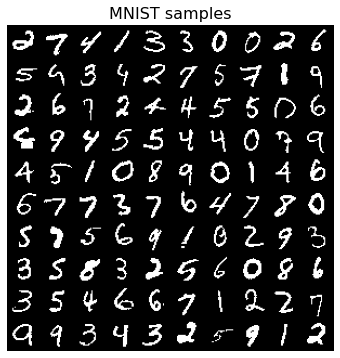

In [6]:
train_data, test_data = load_pickle('mnist.pkl', binarize=True)
visualize_images(train_data, 'MNIST samples')

First of all, let implement the helper functions.

In [7]:
from torch.distributions.kl     import kl_divergence
from torch.distributions.normal import Normal

def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standart normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    
    p1 = Normal(mean_1, torch.exp(log_std_1))
    p2 = Normal(mean_2, torch.exp(log_std_2))
        
    return kl_divergence(p1,p2)
    

def test_KL():
    assert np.isclose (get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)).numpy(), 200.2144, rtol=1e-3)
    assert np.isclose (get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)).numpy(), 1.50925, rtol=1e-3)
    assert np.allclose(get_normal_KL(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(), [49.2990, 1498.479], rtol=1e-3)

test_KL()

We will use PixelCNN model as the VAE decoder.

First of all we need implement masked convolution 2d layer for autoregressive decoder. It is totally the same as the layer that we used in homework 1.

In [22]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5, padding='same', conditional_size=None):
        assert mask_type in ['A', 'B']
        super().__init__(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, self.out_channels)

    def forward(self, input, cond=None):
        self.weight.data*=self.mask
        out = super().forward(input)

        if cond is not None:
            cond = self.cond_op(cond)
            print(out.shape, cond.shape)
            out = out + cond.view(cond.shape[0], self.out_channels, 1, 1)
        return out

    def create_mask(self, mask_type):
        kernel_height = self.kernel_size[0]
        kernel_width  = self.kernel_size[1]
        
        center_y = kernel_height // 2
        center_x = kernel_width  // 2
        
        if mask_type == 'A':
            for k in range(kernel_height):
                for l in range(kernel_width):
                    if k*kernel_width + l <  center_y*kernel_width + center_x:
                        self.mask[:,:,k,l] = 1
        
        if mask_type == 'B':
            for k in range(kernel_height):
                for l in range(kernel_width):
                    if k*kernel_width + l <= center_y*kernel_width + center_x:
                        self.mask[:,:,k,l] = 1

def test_masked_conv2d():
    layer = MaskedConv2d('A', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))
    
    layer = MaskedConv2d('B', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

[Layer Normalization](https://arxiv.org/abs/1607.06450) helps to stabilize training process.

In [16]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

Let implement PixelCNN model.

In [17]:
from collections import OrderedDict

class PixelCNN(nn.Module):
    def __init__(
        self, 
        input_shape, 
        n_filters=256, 
        kernel_size=3, 
        n_layers=7,
        use_layer_norm=True,
        conditional_size=None
    ):
        super().__init__()
        self.input_shape = input_shape
        
        layer_s = None
        
        if use_layer_norm == True :
            layer_s = OrderedDict([
              (f'Conv2d_{1}'     , MaskedConv2d('A', 1, n_filters, kernel_size, conditional_size=conditional_size)),
              (f'LayerNorm2d_{1}', LayerNorm(n_filters)),
              (f'ReLU_{1}'       , nn.ReLU(True))
            ])
            for i in range(2, n_layers):
                layer_s[f'Conv2d_{i}'     ] = MaskedConv2d('B', n_filters, n_filters, kernel_size, conditional_size=conditional_size)
                layer_s[f'LayerNorm2d_{i}'] = LayerNorm(n_filters)
                layer_s[f'ReLU_{i}'       ] = nn.ReLU(True)
            
            layer_s[f'Conv2d_{n_layers}'] = MaskedConv2d('B', n_filters, 2, kernel_size, conditional_size=conditional_size)
        else:
            layer_s = OrderedDict([
              (f'Conv2d_{1}', MaskedConv2d('A', 1, n_filters, kernel_size, conditional_size=conditional_size)),
              (f'ReLU_{1}'  , nn.ReLU(True))
            ])
            for i in range(2, n_layers):
                layer_s[f'Conv2d_{i}'] = MaskedConv2d('B', n_filters, n_filters, kernel_size, conditional_size=conditional_size)
                layer_s[f'ReLU_{i}'  ] = nn.ReLU(True)
            layer_s[f'Conv2d_{n_layers}'] = MaskedConv2d('B', n_filters, 2, kernel_size, conditional_size=conditional_size)
            
        self.net = nn.Sequential(layer_s)

    def forward(self, x, cond=None):
        out = (x.float() - 0.5) * 2
        for layer in self.net:
            if isinstance(layer, MaskedConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        
        return out.view(x.shape[0], 2, 1, *self.input_shape)

    def loss(self, x, cond=None):
        y = self.forward(x, cond)
        total_loss = nn.CrossEntropyLoss()(y, x.long())
        return {'total_loss': total_loss}

    def sample(self, n, cond=None):
        # read carefully the sampling process
        samples = torch.zeros(n, 1, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    #logits = self(samples)[:, :, :, r, c]
                    logits = self(samples, cond=cond)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

We will use simple convolutional encoder here. Look carefully.

In [18]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[0] // 4 * input_shape[1] // 4 * 64
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        x = (x.float() - 0.5) * 2
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std

Now it is time to implement the whole model.

In [19]:
class ARDecoderVAE(nn.Module):
    def __init__(self, input_shape, n_latent, free_bits=None):
        super().__init__()
        assert len(input_shape) == 2

        self.input_shape = input_shape
        self.n_latent    = n_latent
        self.free_bits   = free_bits
        self.encoder     = ConvEncoder(input_shape, n_latent)
        self.decoder     = PixelCNN(
            input_shape, 
            n_filters=32, 
            n_layers=3,
            kernel_size=7, 
            conditional_size=n_latent
        )

    def prior(self, n):
        # ====
        # your code
        # return n samples from prior distribution (we use standart normal for prior)
        # ====
        loc   = torch.zeros(self.n_latent)
        scale = torch.ones (self.n_latent)
        p     = torch.distributions.Normal(loc, scale)
        
        sample_s = p.sample_n(n)
        
        if USE_CUDA:
            sample_s = sample_s.cuda()
        
        return sample_s
           
    def loss(self, x):
        # ====
        # your code
        # 1) apply encoder
        # 2) apply reparametrization trick
        # 3) get decoder loss (reconstruction loss)
        # 4) get kl loss using get_normal_KL
        # 5) apply free_bits
        # ====
        batch_size = x.size(0)
        mu_z, log_std_z = self.encoder(x)
        z = torch.exp(log_std_z)*self.prior( x.size(0) ) + mu_z
        
        #recon_loss = torch.sum(self.decoder.loss(x, z)['total_loss'])
        #kl_loss    = torch.sum(get_normal_KL ( mu_z, log_std_z, torch.zeros_like(mu_z), torch.zeros_like(log_std_z) ))
        recon_loss = torch.sum( self.decoder.loss(x, z)['total_loss'] )
        kl_loss    = torch.sum( torch.clamp(get_normal_KL ( mu_z, log_std_z, torch.zeros_like(mu_z), torch.zeros_like(log_std_z) ), max = self.free_bits) )
          
        
        return {
            'total_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n).cuda()
            samples = self.decoder.sample(n, cond=z)
        return samples

  0%|          | 0/10 [00:00<?, ?it/s]

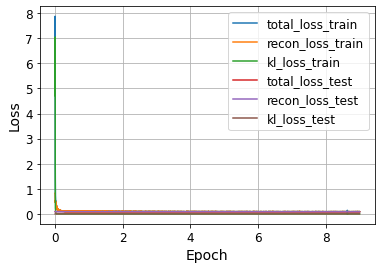

In [20]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 32     # any adequate value
EPOCHS =     10    # < 10 
LR =         5.e-4 # < 1e-2
FREE_BITS =  10    # < 20
# ====

#train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'DGM', 'homework_supplementary', 'mnist.pkl'), binarize=True)
train_data, test_data = load_pickle(os.path.join('mnist.pkl'), binarize=True)


model = ARDecoderVAE(input_shape=(28, 28), free_bits=FREE_BITS, n_latent=32)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, use_cuda=USE_CUDA, use_tqdm=True, lr=LR)

plot_training_curves(train_losses, test_losses)

Note that sampling from our model is sequential now.

total_loss: 0.0849
recon_loss: 0.0849
kl_loss: 0.0000


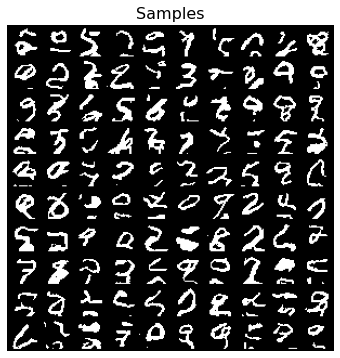

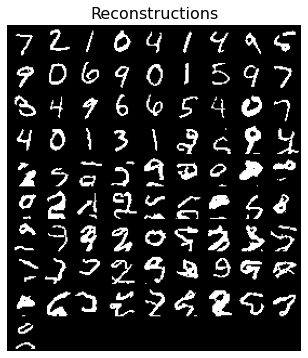

In [23]:
samples = model.sample(100)

x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    z, _ = model.encoder(2 * x - 1)
    x_recon = model.decoder.sample(50, cond=z)
x = x.cpu().numpy()
reconstructions = np.concatenate((x, x_recon), axis=0)

samples = samples.astype('float32')
reconstructions = reconstructions.astype('float32')

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')

# Task 3: VAE with Autoregressive flow-based prior on CIFAR10 (5pt)

In this task you will fit the VAE model with [flow-based prior](https://arxiv.org/abs/1611.02731) to the CIFAR10 dataset. We discussed this topic at Lecture 7.

Download the data from [here](https://drive.google.com/file/d/16j3nrJV821VOkkuRz7aYam8TyIXLnNme/view?usp=sharing) (you could use the cell below).

In [ ]:
!gdown --id 16j3nrJV821VOkkuRz7aYam8TyIXLnNme

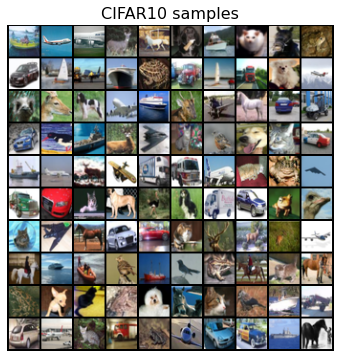

In [24]:
#train_data, test_data = load_pickle('/content/cifar10.pkl')
train_data, test_data = load_pickle('cifar10.pkl')
visualize_images(train_data, 'CIFAR10 samples')

The model consists of:
* convolutional encoder (variational posterior destrituion $q(\mathbf{z} | \mathbf{x})$);
* convolutional decoder (generative distribution $p(\mathbf{x} | \mathbf{z})$);
* autoregressive prior.

We will use MADE model as autoregressive prior. MADE Autoregressive frow (mapping from ${\mathbf{z}\rightarrow {\boldsymbol{\epsilon}}}$) should output location $\mu_{\boldsymbol{\lambda}}(\mathbf{z})$ and scale parameters $\sigma_{\boldsymbol{\lambda}}(\mathbf{z})$. The mapping from ${\mathbf{z}}$ to ${\boldsymbol{\epsilon}}$ has the form:

$$
    {\boldsymbol{\epsilon}} = f(\mathbf{z}, {\boldsymbol{\lambda}}) = \mathbf{z} * \sigma_{\boldsymbol{\lambda}}(\mathbf{z}) + \mu_{\boldsymbol{\lambda}}(\mathbf{z}).
$$

The ELBO objective in this task is:
$$
    \mathcal{L}({\boldsymbol{\phi}}, {\boldsymbol{\theta}}, {\boldsymbol{\lambda}}) = E_{q(\mathbf{z}|\mathbf{x}, {\boldsymbol{\phi}})}[\log{p(\mathbf{x}|\mathbf{z}, {\boldsymbol{\theta}})}] - E_{q(\mathbf{z}|\mathbf{x}, {\boldsymbol{\phi}})}[\log{q(\mathbf{z}|\mathbf{x}, {\boldsymbol{\phi}})} - \log{p(\mathbf{z} | {\boldsymbol{\lambda}})}]
$$
where the logarithm of prior distribution is given by chage of variable (CoV) theorem
$$
    \log{p(\mathbf{z} | {\boldsymbol{\lambda}})} = \log{p({\boldsymbol{\epsilon}})} + \log{\left|\det\left(\frac{d{\boldsymbol{\epsilon}}}{d\mathbf{z}}\right)\right|} = \log{p(f(\mathbf{z}, {\boldsymbol{\lambda}}))} + \log{\left|\det\left(\frac{\partial f(\mathbf{z}, {\boldsymbol{\lambda}})}{\partial \mathbf{z}}\right)\right|}.
$$

Here we define convolutional encoder and decoder. You could use this architecture or experiment with it.

In [25]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * n_latent)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std
        

class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(n_latent, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        return self.deconvs(out)

For autoregressive prior we will use MADE model. Do not change these classes, but read it carefully.

In [26]:
class MaskedLinear(nn.Linear):
    # do not change this class
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    # do not change this class
    def __init__(self, input_shape, d, hidden_size=[512, 512]):
        super().__init__()
        self.input_shape = input_shape
        self.nin = np.prod(input_shape)
        self.nout = self.nin * d
        self.d = d
        self.hidden_sizes = hidden_size
        self.ordering = np.arange(self.nin)

        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()
        self.net = nn.ModuleList(self.net)
        
        self.m = {}
        self.create_mask()

    def create_mask(self):
        L = len(self.hidden_sizes)

        self.m[-1] = self.ordering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(),
                                          self.nin - 1, size=self.hidden_sizes[l])

        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        masks[-1] = np.repeat(masks[-1], self.d, axis=1)

        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x):
        batch_size = x.shape[0]
        out = x.view(batch_size, self.nin)
        for layer in self.net:
            out = layer(out)
        out = out.view(batch_size, self.nin, self.d)
        return out

Let implement VAE with autoregressive prior model.

In [63]:
class ARFPriorVAE(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        assert len(input_shape) == 3
        self.input_shape = input_shape
        self.n_latent = n_latent

        # ====
        # your code
        # define made model, encoder and decoder
        # ====
        self.encoder = ConvEncoder(self.input_shape, self.n_latent)
        self.decoder = ConvDecoder(self.n_latent, self.input_shape)
        self.made    = MADE       (self.n_latent, 2)
        
    def loss(self, x):
        x = 2 * x.float() - 1

        # ====
        # your code
        # 1) apply encoder to x to get variational posterior distribution parameters
        # 2) sample z from variational posterior distribution (reparametrization trick)
        # 3) apply decoder to get reconstruction
        # ====
        n = x.size(0)
                
        mu_z, log_std_z = self.encoder.forward(x)
        z = torch.exp(log_std_z)*self.prior(n) + mu_z
        
        made_mu, made_log_std = torch.chunk((self.made(z)), 2, dim=-1)
        made_mu, made_log_std = made_mu.squeeze(-1), made_log_std.squeeze(-1)
        #made_log_std = torch.tanh(made_log_std)
        tanh_log_std = torch.tanh(made_log_std)
                
        eps = z * torch.exp(tanh_log_std) + made_mu
        r = self.decoder(z)
        
        # ====
        # your code
        # 1) compute reconstruction loss (first term in ELBO) 
        # in this case we could use mse loss 
        # (we will get beta-VAE model since the contributions of reconstruction loss and KL term become dishonest) 
        # 2) compute encoder log prob (it is a log of normal distribution on z)
        # 3) apply MADE model to z to get mu and log_std
        # ====
        
        recon_loss = nn.MSELoss()(x,r)
        
        prior_log_prob     = torch.distributions.Normal(made_mu, torch.exp(tanh_log_std)).log_prob(eps) + (1-tanh_log_std**2)*made_log_std  # log p(z) = log p(𝜖) + log det∣𝑑𝜖/𝑑𝑧∣
        posterior_log_prob = torch.distributions.Normal(mu_z   , torch.exp(log_std_z   )).log_prob(z)
        # ====
        # your code
        # 1) scale z to sigma and shift to mu get epsilon
        # 2) compute prior log prob (log of standart normal)
        # 3) kl loss is difference between encoder log prob and prior log prob
        # ====
        
        beta = 0.000001
        kl_loss = beta*torch.sum( ( posterior_log_prob - prior_log_prob ) )
        
        return {
            'total_loss': recon_loss + kl_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }
    
    def prior(self, n, use_cuda=True):
        # ====
        # your code
        # return n samples from prior distribution (we use standard normal for prior)
        # ====
        loc   = torch.zeros(self.n_latent)
        scale = torch.ones (self.n_latent)
                
        sample_s = torch.distributions.Normal(loc, scale).sample((n,))
        
        if use_cuda:
            sample_s = sample_s.cuda()
        return sample_s

    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n)
            # investigate how to sample from autoregressive model (do not change this part)
            for i in range(self.n_latent):
                mu, log_std = self.made(z)[:, i].chunk(2, dim=-1)
                log_std = torch.tanh(log_std)
                mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
                z[:, i] = (z[:, i] - mu) * torch.exp(-log_std)
            return self.decoder(z).cpu().numpy() * 0.5 + 0.5

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

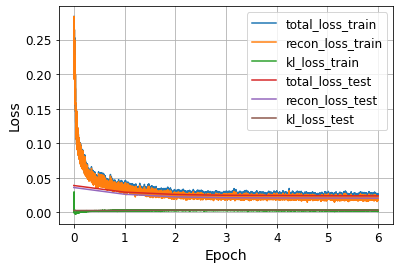

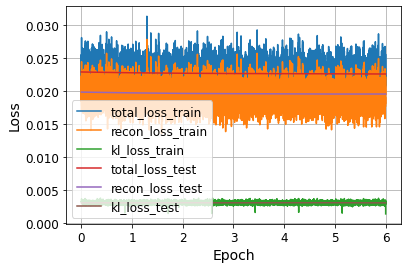

In [64]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 32    # any adequate value
EPOCHS =     7     # < 20
LR =         5.e-4 # < 1e-2
# ====

model = ARFPriorVAE((3, 32, 32), 128)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(test_data , batch_size=BATCH_SIZE)
train_losses_1, test_losses_1 = train_model(model, train_loader, test_loader, use_cuda=USE_CUDA, epochs=EPOCHS, use_tqdm=True, lr=1.e-3)
train_losses_2, test_losses_2 = train_model(model, train_loader, test_loader, use_cuda=USE_CUDA, epochs=EPOCHS, use_tqdm=True, lr=1.e-5)

plot_training_curves(train_losses_1, test_losses_1)
plot_training_curves(train_losses_2, test_losses_2)

total_loss: 0.0580
recon_loss: 0.0558
kl_loss: 0.0022


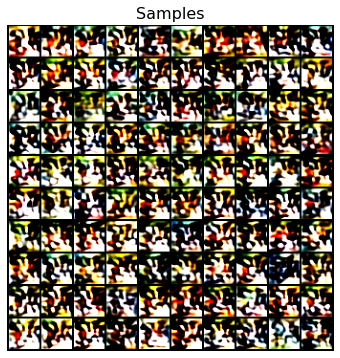

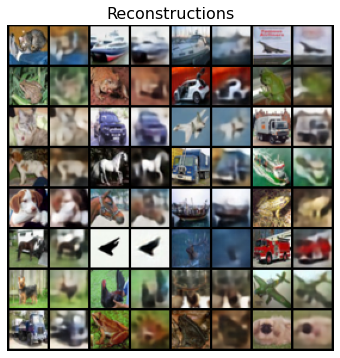

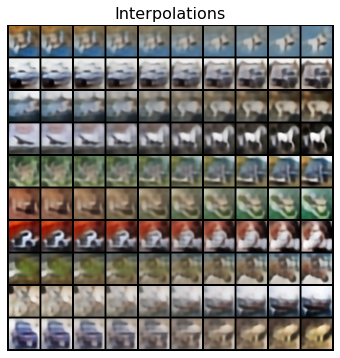

In [65]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]
if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z = model.encoder(2 * x - 1)[0]
    x_recon = torch.clamp(model.decoder(z) * 0.5 + 0.5, 0, 1)

reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32)
reconstructions = reconstructions.cpu()

x = next(iter(test_loader))[:20]
if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    x = 2 * x - 1
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in torch.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps * 0.5 + 0.5, 0, 1)
interps = interps.cpu()

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
    
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')
show_samples(interps, title='Interpolations')

**Note:** we do not use complicated architectures for encoder and decoder in this task. That is why your samples could be blurry, it is ok. The main goal of this task is to understand the theory around flow-based prior. But of course you could experiment with more complex networks (like ResNet) for additional points.